# Moonshot Model: CTA Momentum

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import os
import warnings
import datetime
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

In [2]:
from bs4 import BeautifulSoup
import requests
import time
from selenium import webdriver

#### Uncomment and Run below only to pull entire history

### Load data and clean

In [3]:
dt_meta = pd.read_csv('MarketCapTable.csv')

def clean_currency(x):
    if isinstance(x, str):
        return(x.replace('$', '').replace(',', ''))
    return(x)
dt_meta['Price'] = dt_meta['Price'].apply(clean_currency).astype('float')
dt_meta['Date'] = pd.to_datetime(dt_meta['Date'])
dt_meta.sort_values(by = "Date", ascending = True, inplace = True)

dtraw = dt_meta.loc[:,["Date", "Symbol", "Rank"]]
#Remove stablecoins
remove = ['USDT', 'BUSD', 'UST', 'USDC']
for stk in remove:
    dtraw.drop(dtraw[dtraw["Symbol"]==stk].index, inplace = True)
dtraw.reset_index(drop = True, inplace = True)
dtraw

,Date,Symbol,Rank
0,2013-04-28,NVC,7
1,2013-04-28,BTC,1
2,2013-04-28,LTC,2
3,2013-04-28,DVC,6
4,2013-04-28,NMC,4
...,...,...,...
82173,2021-11-28,BAT,67
82174,2021-11-28,QNT,68
82175,2021-11-28,STX,69
82176,2021-11-28,ONE,59


### Calculate Rank Score from CTA Momentum Signal

In [4]:
#S = [8,16,32]
#L = [24,48,96]

S = [2,4,8]
L = [6,12,24]

#Half Lifes
S_lambda = []
L_lambda = []

for i in range(0,3):
    S_lambda.append(np.log10(0.5)/np.log10(1 - 1/S[i]))
    L_lambda.append(np.log10(0.5)/np.log10(1 - 1/L[i]))

dtraw['Rank'] = 201 - dtraw['Rank']
dt_check = dtraw.loc[:,["Date", "Symbol", "Rank"]]
coins = list(dt_check["Symbol"].unique())
for coin in coins:
    dff = dtraw[dtraw["Symbol"]==coin].reset_index(drop = True)
    for i in range(0,3):    
        dff["EWMA_S"] = dff["Rank"].ewm(halflife=S_lambda[i]).mean()
        dff["EWMA_L"] = dff["Rank"].ewm(halflife=L_lambda[i]).mean()
        dff["x"] = dff["EWMA_S"] - dff["EWMA_L"]
        dff["y"] = dff["x"] / dff["Rank"].rolling(window = 16, min_periods = 16).std()
        dff["z"] = dff["y"] / dff["y"].rolling(window = 63, min_periods = 63).std()
        dff["u"+str(i)] = dff["z"].apply(lambda x:x*np.exp(-x**2/4)/0.89)
    dff["Score"] = (dff["u0"] + dff["u1"] + dff["u2"])/3
    dt_temp = dff.loc[:,["Date", "Symbol", "Rank", "Score"]]
    dt_temp.dropna(inplace = True)
    if coins.index(coin) == 0:
        dt = dt_temp
    else:
        dt = pd.concat([dt, dt_temp], axis = 0, ignore_index=True)

In [5]:
dt

,Date,Symbol,Rank,Score
0,2014-10-19,NVC,162,-0.520063
1,2014-10-26,NVC,165,-0.349508
2,2014-11-02,NVC,163,-0.402602
3,2014-11-09,NVC,158,-0.637398
4,2014-11-16,NVC,162,-0.604288
...,...,...,...,...
26951,2021-11-21,HUSD,15,-0.748148
26952,2021-11-28,HUSD,16,-0.740605
26953,2021-11-28,BAND,3,-0.845949
26954,2021-11-21,CHSB,70,-0.945500


### Create matrix of top 10 coins by date from Score Calculated above

In [6]:
table = pd.pivot_table(dt,index=['Symbol'], columns = 'Date', values = "Score")
topcoins = table.copy()

for i in range(0,len(topcoins.columns)):
    topcoins.iloc[:,i] = topcoins.iloc[:,i].sort_values(ascending = True).index
topcoins = topcoins[0:30]
topcoins.index = range(len(topcoins))
topcoins_raw = topcoins.copy()
topcoins = topcoins[0:10].transpose()
topcoins.tail(10)

,0,1,2,3,4,5,6,7,8,9
Date,,,,,,,,,,
2021-09-26,RLC,MKR,BCD,ANT,DGB,FUN,TOMO,MAID,ZIL,SNX
2021-10-03,TOMO,BCD,ANT,MKR,RLC,SNX,DGB,FUN,OKB,BTG
2021-10-10,DGB,SNX,RLC,MKR,BCD,FUN,XMR,VET,OKB,BTG
2021-10-17,DGB,SNX,MKR,XMR,BCD,ORBS,RLC,OKB,LINK,MAID
2021-10-24,TOMO,DGB,SNX,FUN,ORBS,XMR,MKR,BCD,XEM,MAID
2021-10-31,SNX,BCD,DGB,BTG,OCEAN,XMR,ORBS,DCR,MKR,XEM
2021-11-07,SNX,BTG,BCD,OCEAN,RSR,XMR,DCR,ZIL,CVC,LEO
2021-11-14,BTG,SNX,OCEAN,BCD,CVC,DCR,ZIL,LEO,RSR,XEM
2021-11-21,RSR,XEM,MED,CHSB,DCR,TOMO,ZIL,SNX,BTG,OCEAN


### Create rolling portfolio of top 10 equally weighted coins

In [7]:
weightdf = pd.DataFrame(index = topcoins.index, columns = coins)

for row in weightdf.index:
    for col in weightdf.columns:
        if col in topcoins.loc[row].values:
            weightdf.loc[row,col]=0.1
weightdf.fillna(0, inplace = True)

dfret = pd.pivot_table(dt_meta,index=['Date'], columns = 'Symbol', values = "Price")
dfret = dfret.pct_change().apply(lambda x: np.log(1+x))
dfret = dfret.loc[weightdf.index,weightdf.columns]
dfret.fillna(0, inplace = True)

weight_port = weightdf.copy()
dfret["Port_Ret"] = np.nan
for row in weight_port.index:
    dfret.loc[row,"Port_Ret"] = sum(weight_port.loc[row,:] * dfret.shift(-1).loc[row,][:-1])

### Backtest rolling portfolio

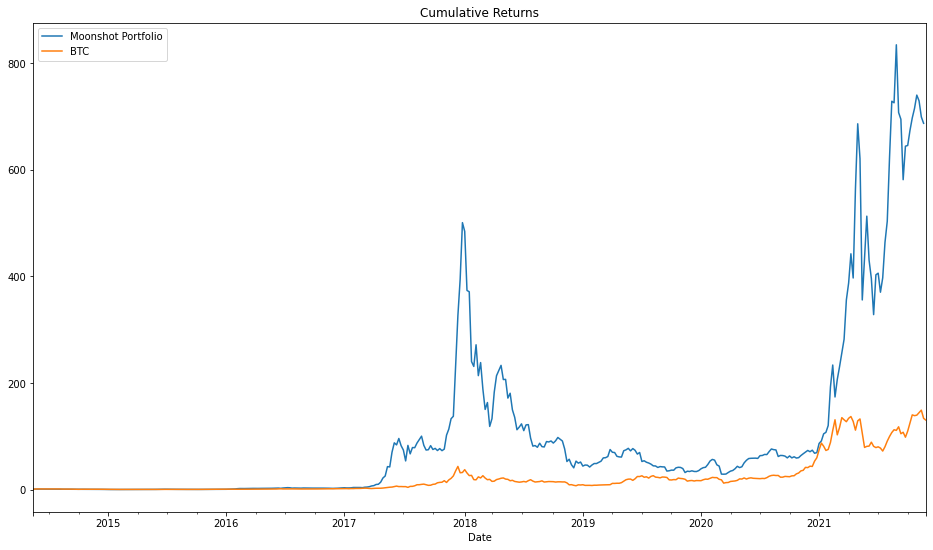

In [8]:
dfret[["Port_Ret", "BTC"]].cumsum().apply(np.exp).plot(figsize = (16,9))
plt.title("Cumulative Returns")
plt.legend(["Moonshot Portfolio", "BTC"])
plt.show()

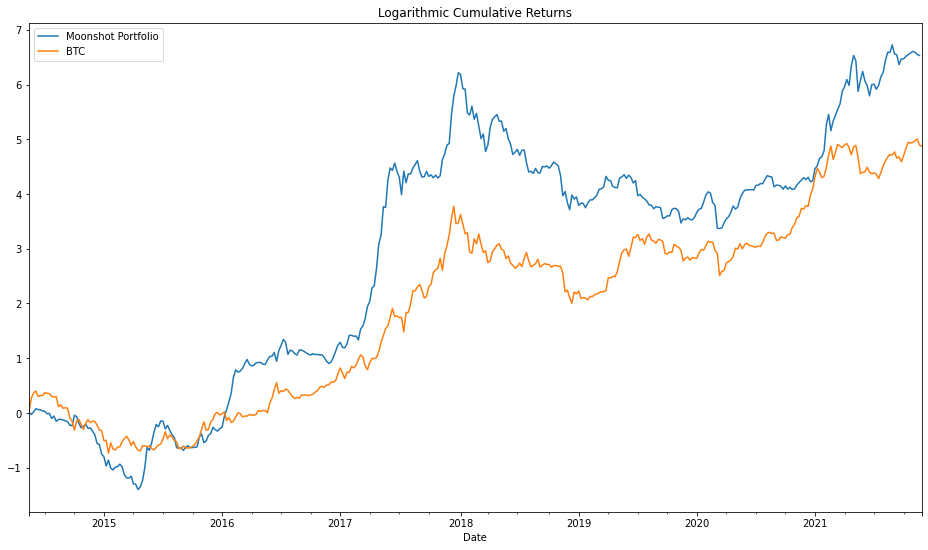

In [9]:
dfret[["Port_Ret", "BTC"]].cumsum().plot(figsize = (16,9))
plt.legend(["Moonshot Portfolio", "BTC"])
plt.title("Logarithmic Cumulative Returns")
plt.show()

### Portfolio Performance Stats

In [13]:
sharpe = dfret["Port_Ret"].mean()/dfret["Port_Ret"].std()*np.sqrt(52)
print("Shape Ratio of the Moonshot Portfolio is " + str(round(sharpe,2)))

Shape Ratio of the Moonshot Portfolio is 0.9


In [11]:
D = (dfret.index[-1] - dfret.index[0]).days
cagr = ((((dfret["Port_Ret"].cumsum().apply(np.exp)[-2]) ** (365.0/D)) - 1)*100)
print("CAGR of the Moonshot Portfolio is " + str(round(cagr,2)) + "%")

CAGR of the Moonshot Portfolio is 137.91%


In [12]:
topcoins.tail(10).transpose()

Date,2021-09-26,2021-10-03,2021-10-10,2021-10-17,2021-10-24,2021-10-31,2021-11-07,2021-11-14,2021-11-21,2021-11-28
0,RLC,TOMO,DGB,DGB,TOMO,SNX,SNX,BTG,RSR,MCO
1,MKR,BCD,SNX,SNX,DGB,BCD,BTG,SNX,XEM,CHSB
2,BCD,ANT,RLC,MKR,SNX,DGB,BCD,OCEAN,MED,RSR
3,ANT,MKR,MKR,XMR,FUN,BTG,OCEAN,BCD,CHSB,XEM
4,DGB,RLC,BCD,BCD,ORBS,OCEAN,RSR,CVC,DCR,DCR
5,FUN,SNX,FUN,ORBS,XMR,XMR,XMR,DCR,TOMO,UBT
6,TOMO,DGB,XMR,RLC,MKR,ORBS,DCR,ZIL,ZIL,MED
7,MAID,FUN,VET,OKB,BCD,DCR,ZIL,LEO,SNX,ZIL
8,ZIL,OKB,OKB,LINK,XEM,MKR,CVC,RSR,BTG,DENT
9,SNX,BTG,BTG,MAID,MAID,XEM,LEO,XEM,OCEAN,TRX
